In [19]:
import itk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import os
import torch
from torch.utils.data import Dataset, DataLoader
import shutil

import pydicom as dicom
import cv2

In [20]:
path = "/Users/schama/Downloads/rsna-breast-cancer-detection/"

In [24]:
class DICOMDataset(Dataset):
    def __init__(self, dicom_dir, csv_file, transform=None):
        self.dicom_dir = dicom_dir
        self.labels = pd.read_csv(csv_file)
        self.imgs_names = os.listdir(dicom_dir)
        #self.imgs_len = len(self.imgs_names)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Load DICOM image
        file_name = self.labels.iloc[idx, 0]
        file_path = os.path.join(self.dicom_dir, file_name)
        image_data = dicom.dcmread(file_path)
        img_array = np.array(image_data.pixel_array, dtype=np.float32)[np.newaxis]
        
        image_data = np.expand_dims(image_data, axis=0)
        image = torch.from_numpy(img_array)
        
        # Load metadata
        label = self.labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            seg = self.transform(seg)
        
        
        return image, label

In [29]:
def plot_batch(batch_imgs, batch_labels):
    batch_size = len(batch_imgs)
    fig, axs = plt.subplots(1, batch_size, figsize=(10,5))
    for i in range(batch_size):
        axs[i].imshow(batch_imgs[i,0,:,:])
        axs[i].set_title(f"Label {batch_labels[i]}")
    plt.show()

In [25]:
dataset = DICOMDataset('./train_test', './labels_test2.csv')
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

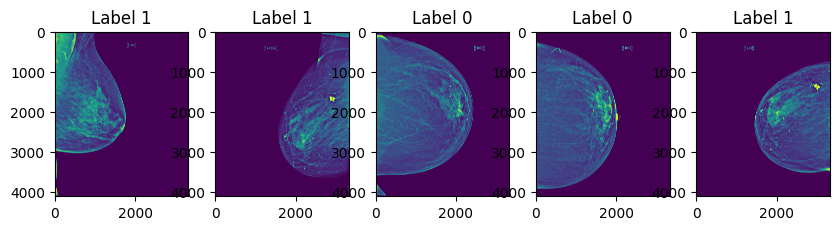

Batch size: torch.Size([5, 1, 4096, 3328])


In [30]:
for batch in dataloader:
    x, y = batch
    plot_batch(x, y)
    print('Batch size:', x.size())
    break

In [ ]:
img = itk.imread(path+'train_images/')

In [5]:
imge_np = itk.array_view_from_image(img)


In [3]:
image_data = dicom.dcmread(path+'train_images/249677.dcm').pixel_array

In [17]:
img = dicom.read_file(path+'train_images/249677.dcm').pixel_array

In [15]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [6]:
image_data.shape

(4096, 3328)

In [12]:
image_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [11]:
x = torch.from_numpy(image_data)

TypeError: can't convert np.ndarray of type numpy.uint16. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [8]:
#x = torch.reshape(image_data, (image_data.shape[0],1))

In [ ]:
# Convert DICOM to JPG/PNG via openCV
def convert_images(filename, img_type='jpg'):
    """Reads a dcm file and saves the files as png/jpg
    
    Args:
        filename: path to the dcm file
        img_type: format of the processed file (jpg or png)
        
    """
    # extract the name of the file
    name = filename.parts[-1]
    
    # read the dcm file
    ds = pydicom.read_file(str(filename)) 
    img = ds.pixel_array
    
    # save the image as jpg/png
    if img_type=="jpg":
        cv2.imwrite(outdir + name.replace('.dcm','.jpg'), img)
    else:
        cv2.imwrite(outdir + name.replace('.dcm','.png'), img)

# Using dask 
all_images = [dd.delayed(convert_images)(all_files[x]) for x in range(len(all_files))]
dd.compute(all_images)